# <center> Sending and receiving a pulse demonstration

### <center> In this demo you will send and receive a pulse in loopback to demonstrate control over the QICK. 

By modifying the <code> config </code> Python dictionary in the below notebook cell, you can change several variables:
* The pulse length <code> pulse_length </code> in FPGA clock ticks (1 clock tick = 2.6 ns).
* The readout buffer length <code> readout_length </code> in FPGA clock ticks.
* The pulse envelope shape <code> pulse_style </code> (either <code> const </code> or <code> arb </code>)
* The pulse amplitude <code> pulse_gain </code> in DAC units.
* The pulse frequency <code> pulse_freq </code> in MHz.
* The readout "time of flight" <code> adc_trig_offset </code> in FPGA clock ticks.
* The number of times you average the read <code> soft_avgs </code>

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Helper function
def gauss(mu=0,si=0,length=100,maxv=30000):
    x = np.arange(0,length)
    y = 1/(2*np.pi*si**2)*np.exp(-(x-mu)**2/si**2)
    y = y/np.max(y)*maxv
    return y

In [3]:
# Load bitstream with custom overlay
soc = QickSoc('../qick_lib/qick.bit')
# Set the loopback DAC channel to be in 1st Nyquist zone mode
soc.set_nyquist(ch=6,nqz=1); 

### Hardware Configuration

tProc channel 6   : DAC 229 CH2  <-> Readout channel 1 : ADC 224 CH1


In [4]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[adcfreq(self.cfg["pulse_freq"])]*2   #add frequency of adc ddc to config
        
        if self.cfg["pulse_style"] == "const":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["pulse_length"])  #add a constant pulse to the pulse library
        if self.cfg["pulse_style"] == "arb":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
        
        freq=freq2reg(adcfreq(cfg["pulse_freq"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        if self.cfg["pulse_style"] == "const":
            self.pulse(ch=self.cfg["res_ch"], length=self.cfg["pulse_length"], play=True) # play readout pulse
        if self.cfg["pulse_style"] == "arb":
            self.pulse(ch=self.cfg["res_ch"], play=True) # play readout pulse
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # sync all channels

### Send/receive a pulse with <code> pulse_style </code> = <code> const </code>

In [5]:
config={"res_ch":6, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":0, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "pulse_length":20, # [Clock ticks]
        # Try varying pulse_length from 10-100 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(config)
di0, dq0, di1, dq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


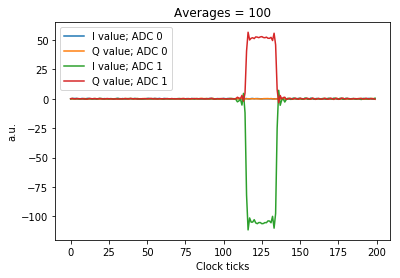

In [6]:
# Plot results.
plt.figure(1)
plt.plot(di0, label="I value; ADC 0")
plt.plot(dq0, label="Q value; ADC 0")
plt.plot(di1, label="I value; ADC 1")
plt.plot(dq1, label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

### Send/receive a pulse with <code> pulse_style </code> = <code> arb </code>

In [7]:
config={"res_ch":6, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":0, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "arb", # --Fixed
        
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":5000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }
config["idata"] = gauss(mu=config["sigma"]*16*5/2,si=config["sigma"]*16,length=5*config["sigma"]*16,maxv=32000)
# Try varying idata to be an arbitrary numpy array of your choosing!

###################
# Try it yourself !
###################

prog =LoopbackProgram(config)
di0, dq0, di1, dq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)


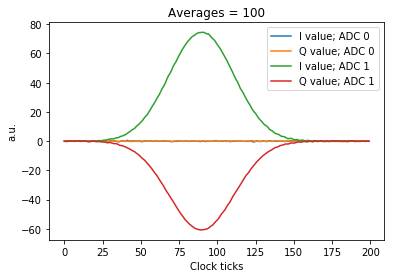

In [8]:
# Plot results.
plt.figure(1)
plt.plot(di0, label="I value; ADC 0")
plt.plot(dq0, label="Q value; ADC 0")
plt.plot(di1, label="I value; ADC 1")
plt.plot(dq1, label="Q value; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
plt.savefig("images/Send_recieve_pulse_arb.pdf", dpi=350)

### Compare the two main ways of acquiring data: <code> prog.acquire_decimated_ds </code> and <code> prog.acquire </code>

In the previous two demonstrations we used <code> prog.acquire_decimated_ds </code> which uses the QICK decimated buffer (acquiring a whole time trace of data for every measurement shot. The QICK accumulated buffer is used in <code> prog.acquire </code>, which acquires a single I/Q data point per measurement shot- the average of the I/Q values in the decimated buffer. In qubit experiments we will be mainly using <code> prog.acquire </code> since for every shot we only need one I/Q value to assess the state of the qubit. So let's verify that <code> prog.acquire_decimated_ds </code> and <code> prog.acquire </code> produce similar results (to within +/- 5 DAC units).

In [9]:
# First, lets collect the results with the decimated buffer as we did before.
config={"res_ch":6, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":0, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "pulse_length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":1000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":100
       }

prog =LoopbackProgram(config)
di0, dq0, di1, dq1 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

In [10]:
print("I value; ADC 0; Decimated buffer: ",  np.sum(di0)/config["readout_length"])
print("Q value; ADC 0; Decimated buffer: ", np.sum(dq0)/config["readout_length"])

I value; ADC 0; Decimated buffer:  0.01345
Q value; ADC 0; Decimated buffer:  -0.01


In [11]:
# Now, lets collect the results with the accumulated buffer. 
config["reps"] = 100; # Set reps equal to soft_avgs in the prior acquisition method

prog =LoopbackProgram(config)
avg_di0, avg_dq0, avg_amp0,avg_di1, avg_dq1, avg_amp1 = prog.acquire(soc, load_pulses=True)

In [12]:
print("I value; ADC 0; Accumulated buffer: ", avg_di0)
print("Q value; ADC 0; Accumulated buffer: ", avg_dq0)

I value; ADC 0; Accumulated buffer:  -0.0031
Q value; ADC 0; Accumulated buffer:  -0.0003


In [13]:
print(prog)


// Program

        regwi 2, $23, 69905066;                 //freq = 99.99999904632568 MHz
        regwi 2, $24, 0;                        //phase = 0
        regwi 2, $26, 1000;                     //gain = 1000
        regwi 2, $28, 0;                        //t = 0
        regwi 2, $27, 589844;                   //stdysel | mode | outsel = 0b01001 | length = 20 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 99;
LOOP_J: regwi 0, $31, 49152;                    //out = 0b1100000000000000
        seti 0, 0, $31, 100;                    //ch =0 out = $31 @t = 0
        regwi 0, $31, 0;                        //out = 0b0000000000000000
        seti 0, 0, $31, 110;                    //ch =0 out = $31 @t = 0
        regwi 2, $27, 589844;                   //stdysel | mode | outsel = 0b01001 | length = 20 
        regwi 2, $28, 0;                        //t = 0
        set 6, 2, $23, $24, $25, $26, $27, $28; //ch = 6, out = $23,$25,$26,$27 @t = $28
        synci 20;
   